Hello!

In this little piece of work I am goin to predict the sentiment of two channels, CNN and BBC, and see which one of those two produce the most positive news.

## Training models

First of all, I am going to train two classifiers on Amazon data and see which one performs better, based on F1 score. 

In [1]:
#loading the data
import numpy as np
import pandas as pd

amc = pd.read_csv('amazon_cells_labelled.txt', header=None, sep = '\t')

amc0 = amc.rename(columns={amc.columns[0]: "text", amc.columns[1]: "score"})
amc0.head()

,text,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [2]:
#cleaning and tokenizing the data
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
morph = pymorphy2.MorphAnalyzer()

nltk.download('punkt')
import re

def clear_data(df):
    df['text'] = df['text'].apply(lambda text: text.strip().split('|')[-1].split('http')[0].strip().lower())
    df['text'] = df['text'].apply(lambda text: re.sub('[\?!:)(«»@#$_1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`&]', '', text))
    return df



def tokenize_and_stem(df):
    df['text'] = df['text'].apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text])
    df['text'] = df['text'].apply(lambda text: ' '.join(text))
    return df


amc_clean0 = clear_data(amc0)
amc_clean = tokenize_and_stem(amc_clean0)
amc_clean.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,score
0,so there is no way for me to plug it in here i...,0
1,"good case , excellent value .",1
2,great for the jawbone .,1
3,tied to charger for conversations lasting more...,0
4,the mic is great .,1


In [3]:
#creating a vector of words out of cleaned and toknized data
words = []


for line in open('stopwords-en.txt'):
    line = line.split('\n') 
    line = line[0]
    words.append(line)

words = frozenset(words)

print('Vectorization of documents')
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1,1), stop_words=(words))

yx = vec.fit_transform(amc_clean['text'])
amc_data = vec.fit_transform(amc_clean['text']).toarray()

num_docs, num_feature = yx.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

Vectorization of documents


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cnn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


documents number :  1000 feature number:  1693


In [4]:
#creating a vector of answers
Y = amc_clean['score'].values
YY = Y.ravel()

#here, I split the data on tarining and test sets with a threshold of 0.33
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(amc_data, Y, test_size=0.33, random_state=42)

print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (330, 1693)
Training collection size:  (670, 1693)


Training Random Forest model

In [5]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# define the parameters for the model
clf = RandomForestClassifier(
    n_estimators=50, # The number of trees in the forest.
    criterion='gini', #  function to measure the quality of a split (Gini impurity and “entropy”)
    max_depth=5, # The maximum depth of the tree
    min_samples_split=2, # The minimum number of samples required to split
    min_samples_leaf=1, # The minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights
    max_features='auto', # The number of features to consider when looking for the best split.
    max_leaf_nodes=None,
    min_impurity_decrease=0.0, # Threshold for early stopping in tree growth. 
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,  # The number of jobs to run in parallel. -1 means using all processors.
    random_state=0, # 
    verbose=0,
    warm_start=False,
    class_weight='balanced')

print('average value f1_macro (5 runs): ')
print(np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')))

average value f1_macro (5 runs): 


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


0.7715423480506086


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


F1 score for Random Forest is 0.77 which is relatively good.
Let's get to another classifier, KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier

#define parameters for the model
neighbors=50
weights = 'uniform'
p = 2

cv_scores_train = []
cv_scores_test = []

# # in the loop, iterate over the number of neighbors and calculate the average value of F1
for k in range(1, neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='auto', leaf_size=30, p=2)
    knn.fit(X_train, y_train)

   # calculating the average value of F1 for different partitions
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
    # calculating the average scores for all partitions
    #print(np.mean(scores))
    cv_scores_train.append(np.mean(scores))
    
    scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='f1_macro')
    # adding the next average value of f1_macro to the list
    cv_scores_test.append(np.mean(scores))
    
print(np.mean(scores))

0.6994059301001274


F1 score for KNN is 0.69 which is lower than for the previous one. Guess I am opting for Random Forest classifier

### Predicting scores for channels

Now, I can proceed to work with CNN and BBC data using the model I've just built

In [7]:
#loading the data
#firts, the dataset for BBC
d1=pd.read_csv('bbchealth.txt',  sep='|', encoding='ANSI', header = None)

print('Dataset size', d1.shape)


d1 = d1.rename(columns={d1.columns[0]: "id", d1.columns[1]: "date", d1.columns[2]: "text"})
#here, I add a new column with the name of the channel
d1['channel'] = 'BBC'
num_rows1, num_feature1 = d1.shape

print('row number: ', num_rows1)
print('feature number: ', num_feature1)
print()
print('names of features: ', list(d1))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (3929, 3)
row number:  3929
feature number:  4

names of features:  ['id', 'date', 'text', 'channel']
-------------------
full data loaded
-------------------


In [8]:
d1.head(5)

,id,date,text,channel
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/...,BBC
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc...,BBC
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc...,BBC
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bb...,BBC
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bb...,BBC


In [9]:
#now, the dataset for CNN
d2=pd.read_csv('cnnhealth.txt',  sep='|', encoding='ANSI', header = None, error_bad_lines=False)

print('Dataset size', d2.shape)


d2 = d2.rename(columns={d2.columns[0]: "id", d2.columns[1]: "date", d2.columns[2]: "text"})
#again, creating a column with channel's name
d2['channel'] = 'CNN'
num_rows2, num_feature2 = d2.shape

print('row number: ', num_rows2)
print('feature number: ', num_feature2)
print()
print('names of features: ', list(d2))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (4045, 3)
row number:  4045
feature number:  4

names of features:  ['id', 'date', 'text', 'channel']
-------------------
full data loaded
-------------------


b'Skipping line 1422: expected 3 fields, saw 4\nSkipping line 1461: expected 3 fields, saw 4\nSkipping line 1468: expected 3 fields, saw 4\nSkipping line 1507: expected 3 fields, saw 4\nSkipping line 1547: expected 3 fields, saw 4\nSkipping line 1728: expected 3 fields, saw 4\nSkipping line 1738: expected 3 fields, saw 4\nSkipping line 1742: expected 3 fields, saw 4\nSkipping line 1847: expected 3 fields, saw 5\nSkipping line 2082: expected 3 fields, saw 4\nSkipping line 2125: expected 3 fields, saw 4\nSkipping line 3860: expected 3 fields, saw 4\n'


In [10]:
d2.head(5)

,id,date,text,channel
0,576880531301801984,Sat Mar 14 23:00:11 +0000 2015,An abundance of online info can turn us into e...,CNN
1,576820122666471424,Sat Mar 14 19:00:08 +0000 2015,A plant-based diet that incorporates fish may ...,CNN
2,576744652717461504,Sat Mar 14 14:00:15 +0000 2015,It doesn't take much to damage your hearing at...,CNN
3,576736754436304896,Sat Mar 14 13:28:52 +0000 2015,RT @CNN: Forever young? Discover this islandвЂ...,CNN
4,576736614766010368,Sat Mar 14 13:28:18 +0000 2015,RT @CNN: Is post-traumatic stress disorder in ...,CNN


In [11]:
#here, I join two datasets
df = d1.append(d2)

print('Dataset size', df.shape)
df.head(5)
#df.tail(5)

Dataset size (7974, 4)


,id,date,text,channel
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/...,BBC
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc...,BBC
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc...,BBC
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bb...,BBC
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bb...,BBC


In [12]:
#cleaning and tokenizing the data
df_clean0 = clear_data(df)
df_clean = tokenize_and_stem(df_clean0)
df_clean.head()

,id,date,text,channel
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,breast cancer risk test devised,BBC
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,gp workload harming care - bma poll,BBC
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,short people 's 'heart risk greater ',BBC
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,new approach against hiv 'promising ',BBC
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,coalition 'undermined nhs ' - doctors,BBC


In [13]:
#creating a vector of words based on the pre-trained on the Amazon data vectorizer
X = vec.transform(df_clean['text'])
chan_data = vec.transform(df_clean['text']).toarray()

num_docs, num_feature = X.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

documents number :  7974 feature number:  1693


In [14]:
#fitting Random Forest classifier
clf.fit(X_train, y_train)

#predicting based on the channels' data 
y_predicted1 = clf.predict(chan_data)

print(y_predicted1) #this is the vector with sentiment scores for channels' dataset 

[0 0 0 ... 0 0 0]


In [15]:
#len(y_predicted1)
df_clean['score'] = y_predicted1 #adding scores to the dataset
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7974 entries, 0 to 4044
Data columns (total 5 columns):
id         7974 non-null int64
date       7974 non-null object
text       7974 non-null object
channel    7974 non-null object
score      7974 non-null int64
dtypes: int64(2), object(3)
memory usage: 373.8+ KB


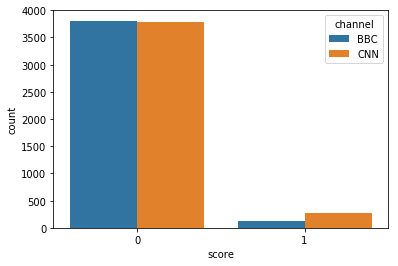

In [18]:
import seaborn as sns 
sns.countplot(x='score', hue='channel', data=df_clean) #plotting scores for each channel

On the graph above it can be seen that the majority of news produced by both channels are rather neutral ('0' score), as predicted by the model. Nevertheless, in case of positive sentiment ('1' score) CNN wins. So, I can assume that CNN produces more positive news. 